# Superstore Sales

Objectives
* Aggregate Sales Data
* Correlations between sales and external factors.
* Identify top-performing products or regions.
* Investigate opportunities for cross- and up-selling.

### I. Imports and Setup

In [25]:
import dotenv
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

import scipy.stats as st
import statsmodels as sm

In [26]:
# TODO 1: Replace current method of URL object creation with secure .env files, adding to .gitignore.

In [27]:
with open("authInfo.txt") as file:
    id = file.read()

# Create SQLAlchemy engine obj to act as conn
url = "mysql://{}/superstore".format(id)
engine = create_engine(url)

### II. Monthly Analysis

In [28]:
monthly_df = pd.read_sql_table(table_name="monthlyfin", con=engine.connect())
monthly_df.head(10)

,YearMonth,OrderCount,DiscountValue,NetSales,NetProfit
0,2014-01,79,10.00,14236.8950,2450.1907
1,2014-02,46,8.10,4519.8920,862.3084
2,2014-03,157,26.30,55691.0090,498.7299
3,2014-04,135,14.85,28295.3450,3488.8352
4,2014-05,122,18.95,23648.2870,2738.7096
5,2014-06,135,23.22,34595.1276,4976.5244
6,2014-07,143,24.55,33946.3930,-841.4826
7,2014-08,153,20.05,27909.4685,5318.1050
8,2014-09,268,42.87,81777.3508,8328.0994
9,2014-10,159,25.45,31453.3930,3448.2573


In [29]:
px.line(data_frame=monthly_df, x="YearMonth", y=["NetSales", "NetProfit"], title="Time Series for Sales and Profit")

In [35]:
monthly_df.describe()

,OrderCount,DiscountValue,NetSales,NetProfit
count,48.000000,48.000000,48.000000,48.000000
mean,208.208333,32.522708,47858.351256,5966.604619
std,104.724148,16.275067,25195.890700,4288.699082
min,46.000000,8.000000,4519.892000,-3281.007000
25%,139.500000,23.655000,29790.096125,2939.567000
50%,173.000000,28.500000,39803.248500,4990.551950
75%,270.500000,42.307500,65833.343625,8742.502275
max,462.000000,73.890000,118447.825000,17885.309300


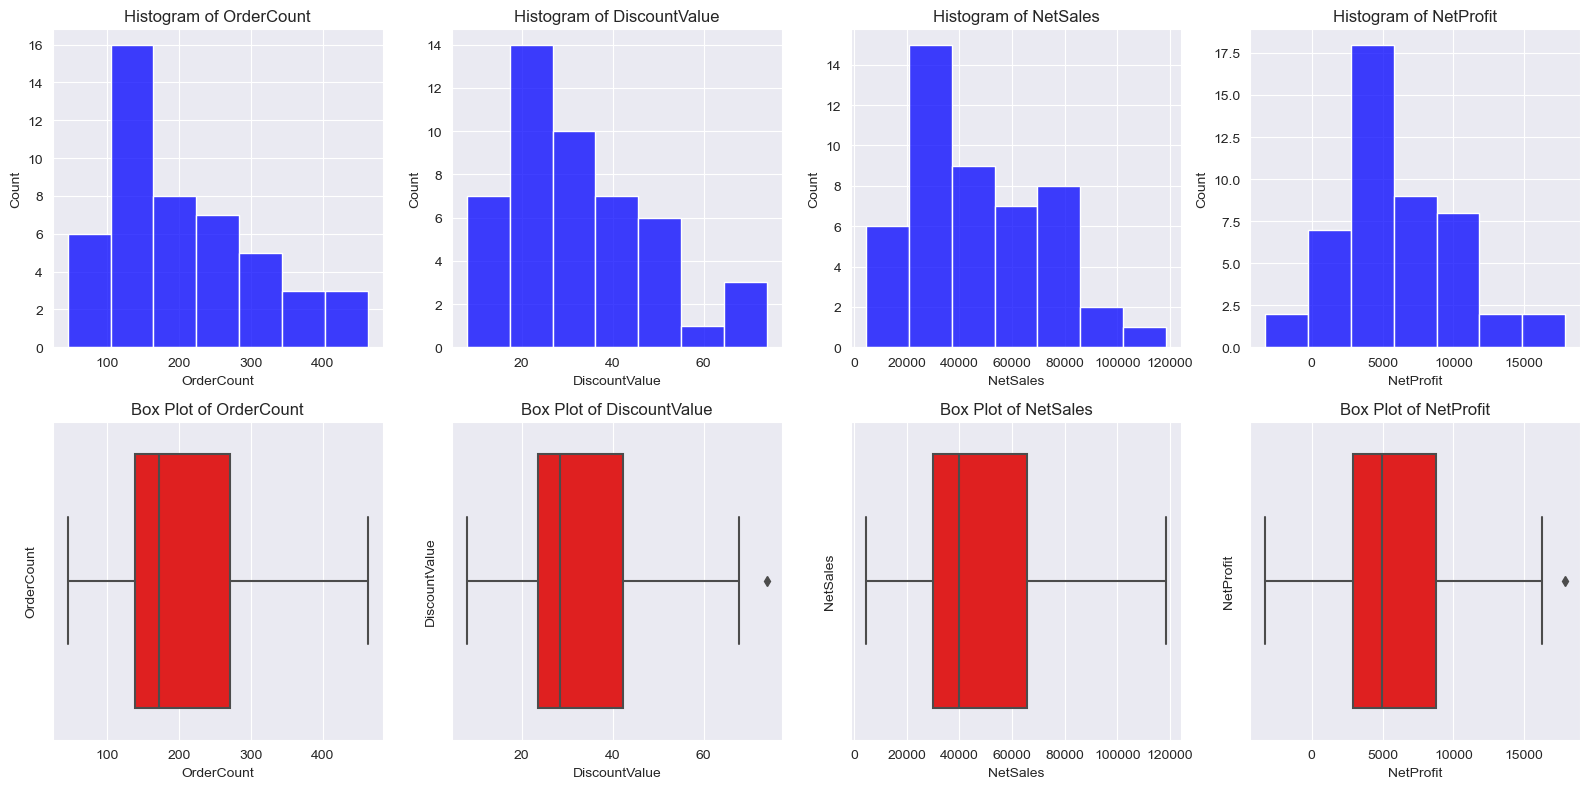

In [31]:
monthly_cols = ['OrderCount', 'DiscountValue', 'NetSales', 'NetProfit']

# Create 2 x 4 subplots
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Create histograms in the first row
for i, col in enumerate(monthly_cols):
    sns.histplot(monthly_df[col], ax=axes[0, i], color='blue')
    axes[0, i].set_title(f'Histogram of {col}')
    axes[0, i].set_xlabel(col)

# Create box plots in the second row
for i, col in enumerate(monthly_cols):
    sns.boxplot(data=monthly_df, x=col, ax=axes[1, i], color='red')
    axes[1, i].set_title(f'Box Plot of {col}')
    axes[1, i].set_ylabel(col)

plt.tight_layout()
plt.show()

In [32]:
# Shapiro-Wilk test for normality of the variables within monthly_df
print("Normal Variables:")
for label in monthly_cols:
    _, p = st.shapiro(monthly_df["NetProfit"])
    if p > .05:
        print('\t * "{}"'.format(label))

Normal Variables:
	 * "OrderCount"
	 * "DiscountValue"
	 * "NetSales"
	 * "NetProfit"


### III. Categorical Analysis

In [33]:
cat_df = pd.read_sql_table(table_name='categories', con=engine.connect())
cat_df

,Category,OrderVolume,SalesVolume,ProfitVolume
0,Technology,1847,836154.0330,145454.9481
1,Office Supplies,6026,719047.0320,122490.8008
2,Furniture,2121,741999.7953,18451.2728


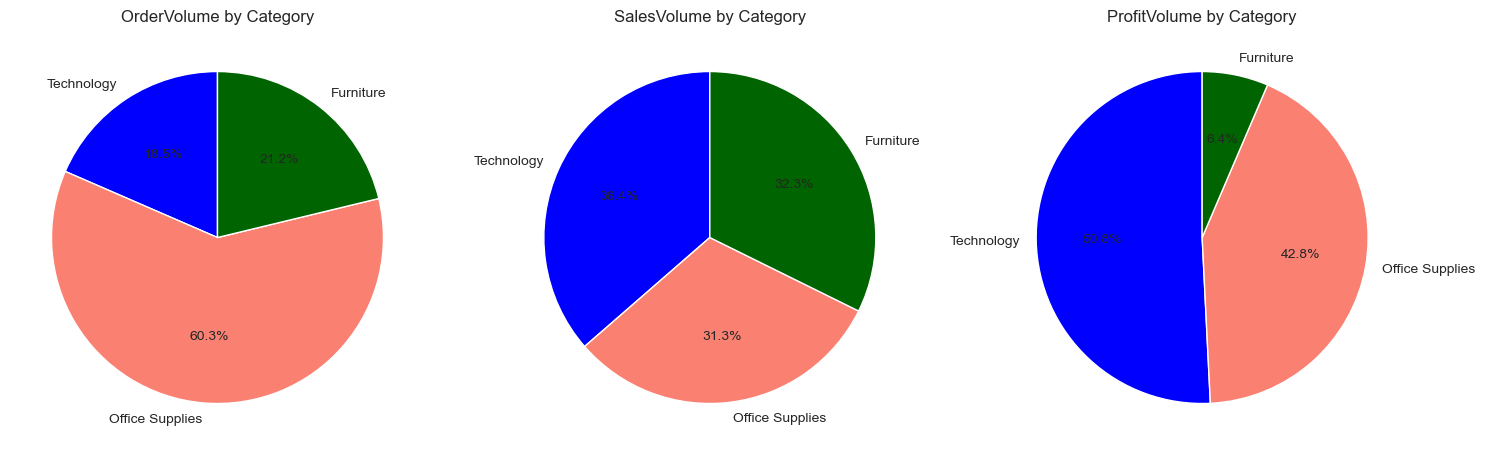

In [34]:
# Plot Pie Charts of OrderVolume, SalesVolume, and ProfitVolume by Category, all on the same axes.
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(['OrderVolume', 'SalesVolume', 'ProfitVolume']):
    axes[i].pie(cat_df[col], labels=cat_df["Category"], autopct='%1.1f%%', startangle=90, colors=['blue', 'salmon', 'darkgreen'])
    axes[i].set_title(f'{col} by Category')

plt.tight_layout()
plt.show()

In [40]:
pd.read_sql_table(table_name="subcategories", con=engine.connect())

,SubCategory,OrderVolume,SalesVolume,ProfitVolume
0,Copiers,68,149528.0300,55617.8249
1,Phones,889,330007.0540,44515.7306
2,Accessories,775,167380.3180,41936.6357
3,Paper,1370,78479.2060,34053.5693
4,Binders,1523,203412.7330,30221.7633
5,Chairs,617,328449.1030,26590.1663
6,Storage,846,223843.6080,21278.8264
7,Appliances,466,107532.1610,18138.0054
8,Furnishings,957,91705.1640,13059.1436
9,Envelopes,254,16476.4020,6964.1767


In [44]:
#copiers_df = pd.read_sql_table(table_name="copiers", con=engine.connect())
# copiers_df.head(10)

**INSIGHT**: So, it looks like Technology makes up the smallest portion (< 20%) of orders, but accounts for about 30% of all Sales, and just over 50% of all Profits. Copiers, in particular, such the *Brother DCP1000* are the most profitable tech product our Superstore has to offer.

In [43]:
# TODO: Investigate who is buying copiers!